In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)

# Useful functions

In [16]:
def date_str_from_month_number(month_number, first_month_str='2019-08'):
    '''
    Returns a date string from `month_number` after the first month (`first_month_str`)
    Ex. 
        (month_number=0, first_month_str='2019-08') returns '2019-08-01'
        (month_number=1, first_month_str='2019-08') returns '2019-09-01'
        (month_number=38, first_month_str='2019-08') returns '2022-10-01'
    '''
    date = pd.to_datetime(first_month_str, format='%Y-%m') + pd.DateOffset(months=month_number)    
    return f'{date.year}-{date.month:02}-01'

def append_na_rows(g, insert_rows=8):
    x = g.copy().reset_index(0, drop=True)
    x = x.reindex(index=range(insert_rows + len(x))) 
    x['month_number'] = x.index.astype(int)    
    x['first_day_of_month'] = x['month_number'].apply(date_str_from_month_number)
    for column in ['cfips', 'county', 'state']:
        x[column] = x[column].unique()[0]
    x['row_id'] = x['cfips'] + '_' + x['first_day_of_month']
    return x

def plot(d, nfigs=12, ncols=6):    
    nrows = int(np.ceil(nfigs/ncols))
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*3, nrows*3), sharey=False)

    for i, cfips in enumerate(d.cfips.unique()):
        if i >= nfigs:
            break
        idx_row = int(i / ncols)
        idx_col = i % ncols
        if nrows == 1:
            ax = axs[idx_col]
        else:
            ax = axs[idx_row, idx_col]

        g = d.loc[d.cfips == cfips, :].reset_index(0, drop=True)        
        ax.plot(g.index, g.y, 'o-', label='raw')
        ax.plot(g.index, g.yhat, 'o-', label='predicted')
        if idx_row == 0 and idx_col == ncols-1:
            ax.legend(fancybox=False)
    
    fig.tight_layout()

def convert_submission(d):
    s = d.loc[d['month_number'] >= 39, :].copy()
    s['cfips_int'] = s['cfips'].astype(int)
    s = s.sort_values(by=['month_number', 'cfips_int'])
    s['microbusiness_density'] = s['yhat']
    s = s.loc[:, ['row_id', 'microbusiness_density']]
    s.to_csv('submission.csv', index=False)

# Load data

In [3]:
d = pd.read_csv('../data/train.csv') # data for 3135 cfips with 39 months each (total = 3135*39 = 122265 rows)
d['y'] = d['microbusiness_density']
d = d.drop(['active', 'microbusiness_density'], axis=1)
d['cfips'] = d['cfips'].astype(str)
d = d.groupby('cfips').apply(append_na_rows).reset_index(0, drop=True)
d

,row_id,cfips,county,state,first_day_of_month,y,month_number
0,10001_2019-08-01,10001,Kent County,Delaware,2019-08-01,4.995701,0
1,10001_2019-09-01,10001,Kent County,Delaware,2019-09-01,5.031902,1
2,10001_2019-10-01,10001,Kent County,Delaware,2019-10-01,5.098270,2
3,10001_2019-11-01,10001,Kent County,Delaware,2019-11-01,5.124666,3
4,10001_2019-12-01,10001,Kent County,Delaware,2019-12-01,5.086203,4
...,...,...,...,...,...,...,...
42,9015_2023-02-01,9015,Windham County,Connecticut,2023-02-01,NaN,42
43,9015_2023-03-01,9015,Windham County,Connecticut,2023-03-01,NaN,43
44,9015_2023-04-01,9015,Windham County,Connecticut,2023-04-01,NaN,44
45,9015_2023-05-01,9015,Windham County,Connecticut,2023-05-01,NaN,45


# Linear regression

In [4]:
def get_linear_pred(g):
    x = g.copy().reset_index(0, drop=True)
    g = g.dropna()
    linear_model = np.poly1d(np.polyfit(g.month_number, g.y, 1))
    yhat = linear_model(x.month_number)    
    x['yhat'] = yhat
    return x

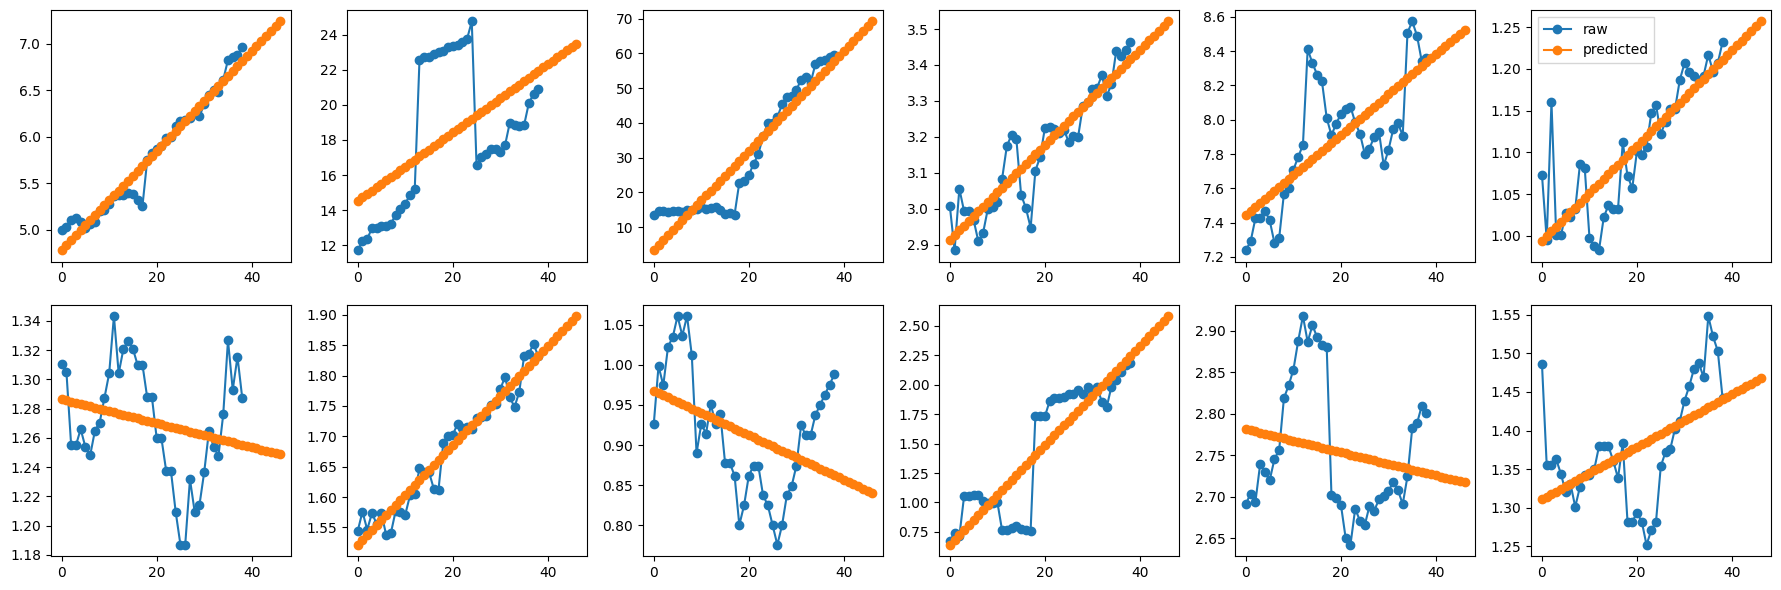

In [5]:
p = d.groupby('cfips', group_keys=True).apply(get_linear_pred).reset_index(0, drop=True)
plot(p)

In [17]:
convert_submission(p)

# ARIMA